# CNN w/ Keras on TF
## We compare 3 different model architectures with & without data augmentation and 

# Set up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import stats

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.utils import to_categorical # For keras > 2.0
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#for model3
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

Using TensorFlow backend.


# Data Preprocessing

In [3]:
train = pd.read_csv("~/.kaggle/competitions/digit-recognizer/train.csv")
test = pd.read_csv("~/.kaggle/competitions/digit-recognizer/test.csv")

In [4]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

*"Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive."*

In [5]:
print(Y_train.shape)
print(X_train.shape)

(42000,)
(42000, 784)


In [6]:
print(X_train.min().min())
print(X_train.max().max())
# print(X_train.shape)

0
255


We reshape the data from pandas.Dataframes of 1D vectors of 784 values to 3D (28x28x1) matrices. The 3rd dim is req'd by Keras, corresponding to channels. Since MNIST images are gray scaled, so it uses only one channel (as opposed to RGB images having 3 channels). 

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

We encode Y_train (training labels) to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [8]:
print(Y_train.shape)
print(Y_train.describe())
print(np.array(Y_train.head()))

(42000,)
count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64
[1 0 1 4 0]


In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [10]:
print(Y_train.shape)
print(pd.DataFrame(Y_train).describe())

(42000, 10)
                  0             1             2             3             4  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       0.098381      0.111524      0.099452      0.103595      0.096952   
std        0.297833      0.314783      0.299272      0.304738      0.295896   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  5             6             7             8             9  
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000  
mean       0.090357      0.098500      0.104786      0.096738      0.099714  
std        0.286696      0.297993      0.3

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

We split training and valdiation set 

In [11]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


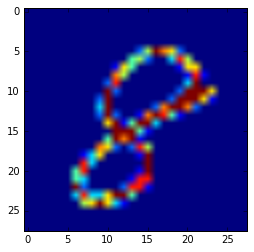

In [12]:
print(Y_train[0])
plt.imshow(X_train[0][:,:,0])

# Define the CNN models
We start by comparing three different model architectures, all sharing some common attributes

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 86

img_rows, img_cols = 28, 28

nb_filters_1 = 32 
nb_filters_2 = 64 
nb_filters_3 = 128 

nb_conv = 3 # kernel_size dim
nb_classes = Y_train.shape[1]


## CNN Model #1:
Based on [yassineghouzam](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6). 

**Layer 1, 2, 5, 6:** convolutional (Conv2D) layer with nb_filters_1 (32) filters for 1&2 and nb_filters_2 (64) filters for 5&6. Each filter transforms a part of the image defined by the kernel size nb_conv (3) using the kernel filter. 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

**Layer 3, 7:** Each sequence of two convolution (Conv2D) layers os followed by the pooling (MaxPool2D) layer, which acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value (reduce computational cost, reduce overfitting). 

*Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.*

**Layer 4, 8, 11:** Each pooling layer is followed by dropout (Dropout), is a regularization method in which a random proportion of the nodes in a layer are randomly ignored by setting their wieghts to zero. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

**Layer 9:** The Flatten layer converts the final feature maps into a one single 1D vector. It combines all the found local features of the previous convolutional layers and makes it possible to use of fully connected layers after the convolutional/maxpool layers. 

**Layer 10, 12:** Finally, two fully-connected (Dense) layers which are just artificial an neural networks (ANN) classifiers. In the last layer(Dense(10,activation="softmax")), the net outputs distribution of probability of each class.

**Without data augmentation: After 02 epochs:** val_acc: 0.9821<br>
**Without data augmentation: After 30 epochs:** val_acc: 0.9919



In [81]:
model1 = Sequential()
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model1.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(nb_classes, activation = "softmax"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
__________

In [93]:
history1 = pickle.load( open( 'model1_history_30epochs.p', 'rb'))

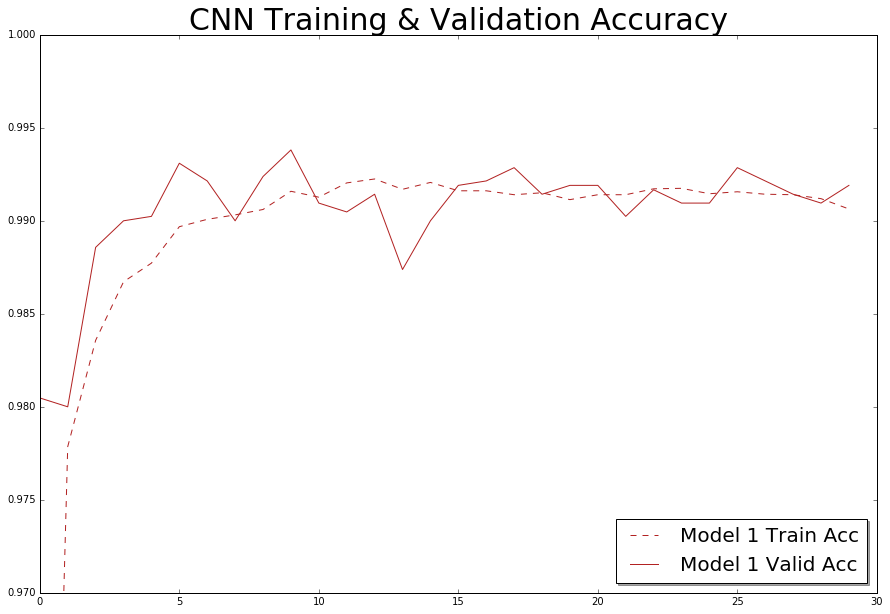

In [134]:
# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.97)

plt.plot(history1['acc'], color='firebrick', linestyle='--', label="Model 1 Train Acc")
plt.plot(history1['val_acc'], color='firebrick',label="Model 1 Valid Acc")

plt.title("CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True)

## CNN Model #2:
Based on [somshubramajumdar](https://www.kaggle.com/somshubramajumdar/deep-convolutional-network-using-keras). 

Same as Model #1 except we drop (!) both of the Dropout layers following the first and second set of Conv2D+Conv2D+MaxPool2D. Thefinal sequence of Flatten+Dense+Dropout+Dense is replaced by Flatten+Dropout+Dense+Dense. The second to last Dense layer's ouput space dim is half that of Model#1 (128 vesus 256). Also, adam is used as the update rule instead of RMSProp.

Comparing the accuracy of these two models, model 2 exhibits more overfitting but ultimately performs just as well as model 1. 

**Without data augmentation: After 30 epochs:** val_acc: 0.9900

[*"in CNN, usually, a Dropout layer is applied after each pooling layer, and also after your Dense layer. A good tutorial is here"*](https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)

In [114]:
model2 = Sequential()

model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))
model2.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(strides=(2,2)))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation = "relu"))
model2.add(Dense(nb_classes, activation = "softmax"))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 3136)              0         
__________

In [120]:
history2 = pickle.load( open( 'model2_history_30epochs.p', 'rb'))

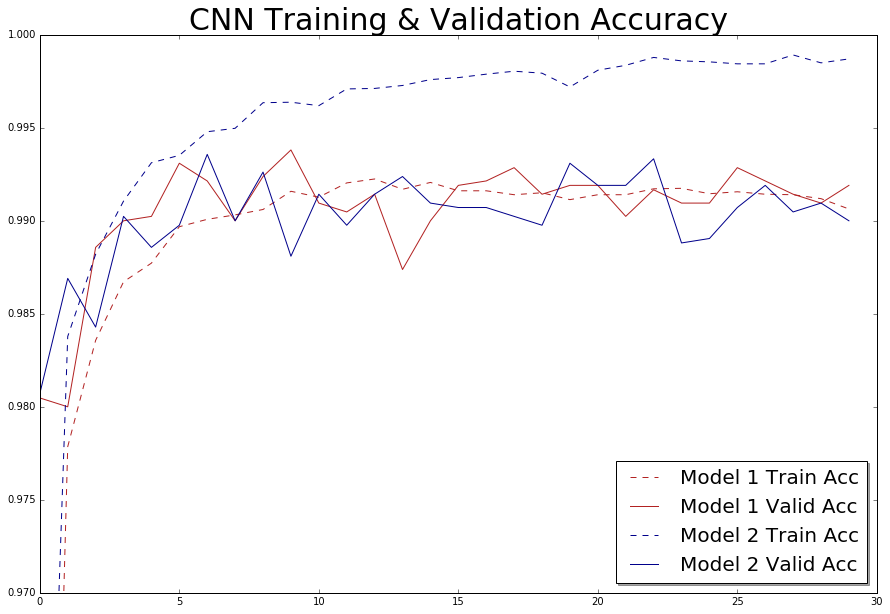

In [135]:
# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.97)
plt.plot(history1['acc'], color='firebrick', linestyle='--', label="Model 1 Train Acc")
plt.plot(history1['val_acc'], color='firebrick',label="Model 1 Valid Acc")
plt.plot(history2['acc'], color='darkblue', linestyle='--', label="Model 2 Train Acc")
plt.plot(history2['val_acc'], color='darkblue',label="Model 2 Valid Acc")
plt.title("CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True)

## CNN Model #3:
Based on [yashk2810.github]( https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/). 

A completely different architecture! We keep our individual **Conv2D** layers the same in terms of filters and kernel size values, but now instead for the padding parameter being 'Same', it is set to the default 'Valid'. Lastly, activation in these layers is set to the default of None, and only implemented after Batch Normalization. 

No longer are we stringing two Conv2D layers together. Instead, each Conv2D layer is followed by BatchNormalization and Activation, for a total of 4 sequences of Conv2D+BatchNormalization+Activation. 

**BatchNormalization**: performs normalization for each training mini-batch, allowing us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout. 

**Activation**: In previous models, this was incorporated intp the Conv2D layer but now, we save this for after BatchNormalization. It is debatable whether Activation should precede or follow BatchNormalization. 

After ever 2 sequences of Conv2D+BatchNormalization+Activation, we follow with a MaxPool2D of the same size as in the previous two models.

Finally, we wrap up with a sequence of Flatten+Dense+BatchNormalization+Activation and Dropout+Dense(nb_classes). Our Second to last dense layer's ouput space dim is twise that of Model#1 (512 vesus 256) and four times that of Model#2  (512 vesus 128).

Our optimizer is the same as in Model #2 - "Adam". 

Comparing the accuracy of these three models, model 3 exhibits similar behavior of model 2 -- more overfitting but ultimately performs (exactly!) just as well as model 1.  Could this be tied to using Adam instad of RMSProp? 

**Without data augmentation: After 30 epochs:** val_acc: 0.9919

In [137]:
model3 = Sequential()

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))                
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(Conv2D(filters = nb_filters_1, 
                  kernel_size = (nb_conv,nb_conv),
                  input_shape=(28,28,1)))  
model3.add(BatchNormalization(axis=-1))
model3.add(Activation('relu'))

model3.add(MaxPool2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(Dropout(0.2))
model3.add(Dense(nb_classes, activation = "softmax"))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 32)        0         
__________

In [139]:
history3 = pickle.load( open( 'model3_history_30epochs.p', 'rb'))

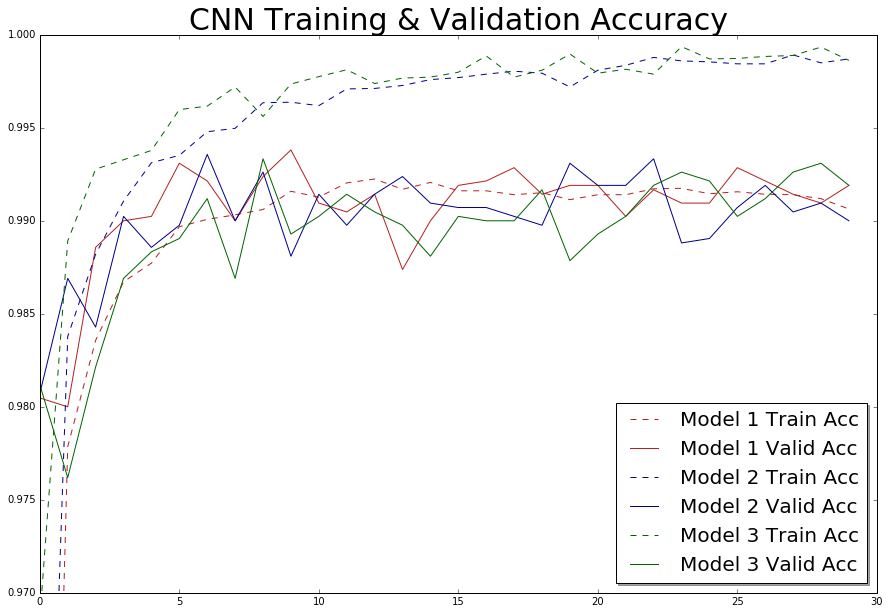

In [140]:
# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.97)

plt.plot(history1['acc'], color='firebrick', linestyle='--', label="Model 1 Train Acc")
plt.plot(history1['val_acc'], color='firebrick',label="Model 1 Valid Acc")
plt.plot(history2['acc'], color='darkblue', linestyle='--', label="Model 2 Train Acc")
plt.plot(history2['val_acc'], color='darkblue',label="Model 2 Valid Acc")
plt.plot(history3['acc'], color='darkgreen', linestyle='--', label="Model 3 Train Acc")
plt.plot(history3['val_acc'], color='darkgreen',label="Model 3 Valid Acc")

plt.title("CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True)

In [136]:


# With data augmentation to prevent overfitting (accuracy 0.99286)

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images


# datagen.fit(X_train)

# Fit the model
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_val,Y_val),
#                               verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

## CNN Model #4:

I tried adding BatchNormalization to the second model, between the convolution and activation layers. However, this did not really improve perfomance. 

Comparing the accuracy of these three models, model 4 exhibits similar behavior of model 2 & 4 -- more overfitting but ultimately has more volatily validation scores. 

**Without data augmentation: After 30 epochs:** val_acc:  0.9902

In [14]:
model4 = Sequential()

model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same', 
                 input_shape = (28,28,1)))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_1, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2,2)))

model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(Conv2D(filters = nb_filters_2, 
                 kernel_size = (nb_conv,nb_conv),
                 padding = 'Same'))
model4.add(BatchNormalization(axis=-1))
model4.add(Activation('relu'))
model4.add(MaxPool2D(strides=(2,2)))

model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(128, activation = "relu"))
model4.add(Dense(nb_classes, activation = "softmax"))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [144]:
history4 = pickle.load( open( 'model4_history_30epochs.p', 'rb'))

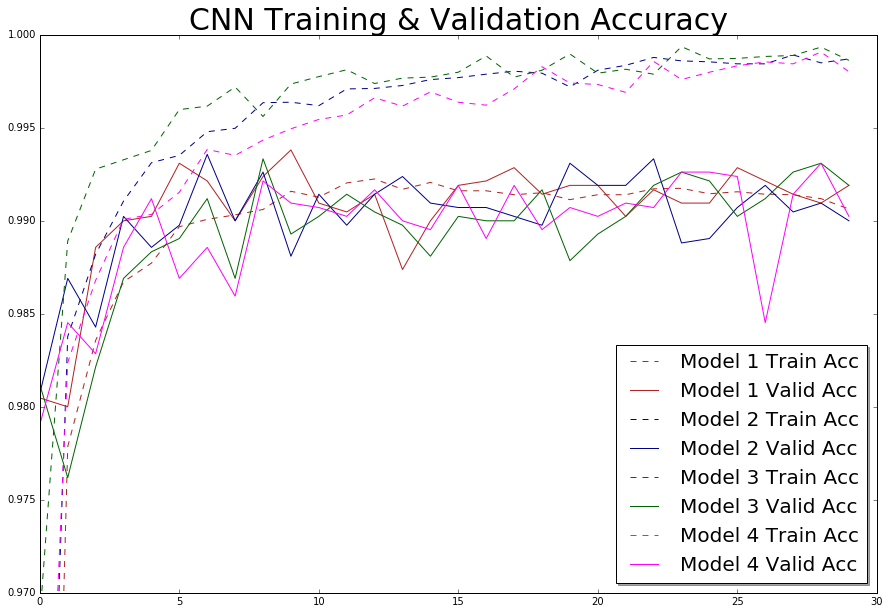

In [151]:
# Plot the loss and accuracy curves for training and validation 
plt.rcParams['figure.figsize'] = [15, 10]
plt.ylim(ymin=.97)

plt.plot(history1['acc'], color='firebrick', linestyle='--', label="Model 1 Train Acc")
plt.plot(history1['val_acc'], color='firebrick',label="Model 1 Valid Acc")
plt.plot(history2['acc'], color='darkblue', linestyle='--', label="Model 2 Train Acc")
plt.plot(history2['val_acc'], color='darkblue',label="Model 2 Valid Acc")
plt.plot(history3['acc'], color='darkgreen', linestyle='--', label="Model 3 Train Acc")
plt.plot(history3['val_acc'], color='darkgreen',label="Model 3 Valid Acc")
plt.plot(history4['acc'], color='fuchsia', linestyle='--', label="Model 4 Train Acc")
plt.plot(history4['val_acc'], color='fuchsia',label="Model 4 Valid Acc")

plt.title("CNN Training & Validation Accuracy", fontsize=30)
plt.legend(loc=4, prop={'size': 20}, shadow=True)

# Data Augmentation

## 3.3 Data augmentation 

# 4. Evaluate the model
## 4.1 Training and validation curves

/usr/lib/python2.7/dist-packages/matplotlib/artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


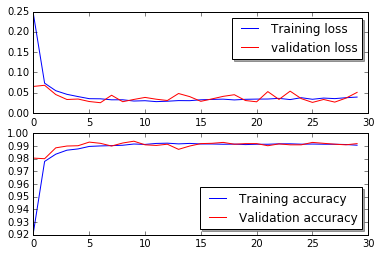

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

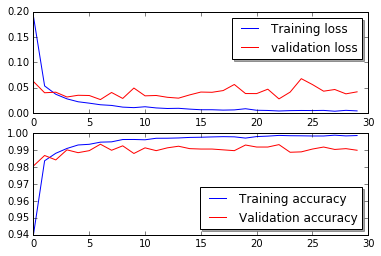

In [21]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history2.history['loss'], color='b', label="Training loss")
ax[0].plot(history2.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history2.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history2.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

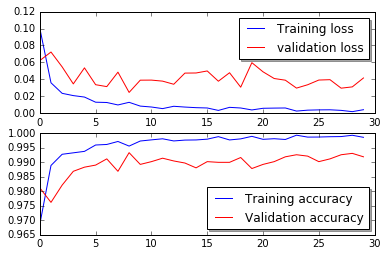

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history3.history['loss'], color='b', label="Training loss")
ax[0].plot(history3.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history3.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history3.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

In [23]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

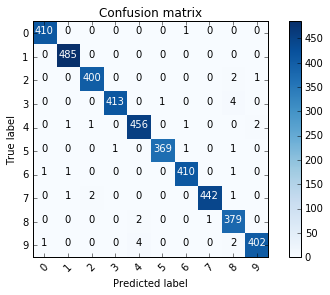

In [24]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

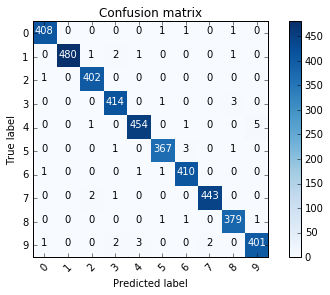

In [25]:
# Predict the values from the validation dataset
Y_pred2 = model2.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes2 = np.argmax(Y_pred2,axis = 1) 
# Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx2 = confusion_matrix(Y_true, Y_pred_classes2) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx2, classes = range(10)) 

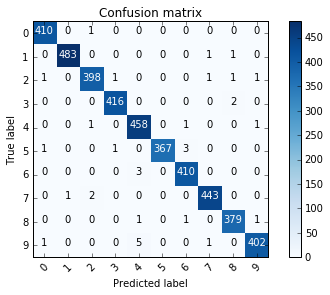

In [26]:
# Predict the values from the validation dataset
Y_pred3 = model3.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes3 = np.argmax(Y_pred3,axis = 1) 
# Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx3 = confusion_matrix(Y_true, Y_pred_classes3) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx3, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors. 

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

In [55]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


In [56]:
def det_most_important_errors(Y_pred_errors, Y_true_errors, ):
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

    # Sorted list of the delta prob errors
    sorted_delta_errors = np.argsort(delta_pred_true_errors)

    return sorted_delta_errors

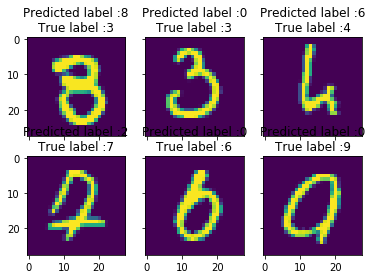

In [58]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

most_important_errors = det_most_important_errors(Y_pred_errors, Y_true_errors)

# Show the top 6 errors
display_errors(most_important_errors[-6:], X_val_errors, Y_pred_classes_errors, Y_true_errors)

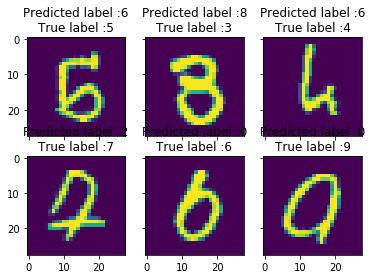

In [59]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors2 = (Y_pred_classes2 - Y_true != 0)

Y_pred_classes_errors2 = Y_pred_classes[errors2]
Y_pred_errors2 = Y_pred[errors2]
Y_true_errors2 = Y_true[errors2]
X_val_errors2 = X_val[errors2]

most_important_errors2 = det_most_important_errors(Y_pred_errors2, Y_true_errors2)

# Show the top 6 errors
display_errors(most_important_errors2[-6:], X_val_errors2, Y_pred_classes_errors2, Y_true_errors2)

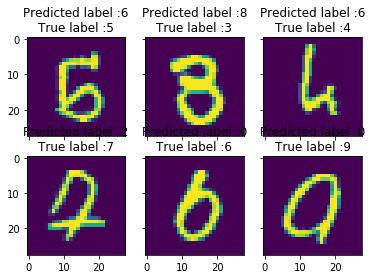

In [79]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors3 = (Y_pred_classes3 - Y_true != 0)

Y_pred_classes_errors3 = Y_pred_classes[errors3]
Y_pred_errors3 = Y_pred[errors3]
Y_true_errors3 = Y_true[errors3]
X_val_errors3 = X_val[errors3]

most_important_errors3 = det_most_important_errors(Y_pred_errors3, Y_true_errors3)

# Show the top 6 errors
display_errors(most_important_errors3[-6:], X_val_errors3, Y_pred_classes_errors3, Y_true_errors3)

In [61]:
most_important_errors

array([57, 52, 67, 27, 33, 31, 64, 18, 56, 72, 55, 26, 47, 71, 36, 65, 15,
       41,  8,  1, 37, 14, 16, 46, 13, 23, 12,  7, 19, 59,  2, 25,  5,  4,
       50, 20, 22, 11, 38, 70, 49, 35, 53, 24, 58,  0, 44, 28, 17, 69, 43,
       48, 73,  6, 61, 66, 63, 29, 30, 42,  3, 34,  9, 32, 60, 40, 51, 10,
       21, 39, 54, 68, 62, 74, 45])

In [62]:
most_important_errors2

array([29, 31, 24, 45, 21, 20, 34, 35, 15, 36, 13, 27, 37, 42,  2,  4, 44,
       40, 17, 30,  1, 10,  7, 11, 32,  5, 19, 28, 14,  0, 23, 43, 26,  6,
       39, 16,  3,  8, 18, 33,  9, 12, 22, 41, 38, 46, 25])

The most important errors are also the most intrigous. 

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

In [29]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [60]:
# predict results
results2 = model2.predict(test)

# select the indix with the maximum probability
results2 = np.argmax(results2,axis = 1)

results2 = pd.Series(results2,name="Label")

submission2 = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results2],axis = 1)

submission2.to_csv("cnn_mnist_datagen2.csv",index=False)



** you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - That will keep me motivated :)**
